# 제주도 도로 교통량 예측

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn. impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.formula.api import ols
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import skew
from scipy.stats import kurtosis

In [ ]:
# connect google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
plt.rc('font', family='NanumBarunGothic')

## 자료 읽기

In [ ]:
#df=pd.read_csv('/content/gdrive/MyDrive/숙탯_여름/train.csv')
#df

In [ ]:
#testcsv=pd.read_csv('/content/gdrive/MyDrive/숙탯_여름/test.csv')

In [ ]:
#용량이 너무 크므로 parquet 파일로 저장하기
#df.to_parquet('/content/gdrive/MyDrive/숙탯_여름/train.parquet')
#testcsv.to_parquet('/content/gdrive/MyDrive/숙탯_여름/test.parquet')

In [ ]:
train=pd.read_parquet('/content/gdrive/MyDrive/숙탯_여름/train.parquet')
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [ ]:
test=pd.read_parquet('/content/gdrive/MyDrive/숙탯_여름/test.parquet')
test.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
0,TEST_000000,20220825,목,17,3,107,연삼로,0,0,70.0,...,0.0,0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음
1,TEST_000001,20220809,화,12,2,103,일반국도12호선,0,0,70.0,...,0.0,3,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음
2,TEST_000002,20220805,금,2,1,103,일반국도16호선,0,0,60.0,...,0.0,0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음
3,TEST_000003,20220818,목,23,3,103,일반국도11호선,0,0,70.0,...,0.0,0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음
4,TEST_000004,20220810,수,17,3,106,번영로,0,0,70.0,...,0.0,0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음


In [ ]:
#변수 정보 read
df_info=pd.read_csv('/content/gdrive/MyDrive/숙탯_여름/data_info.csv')
df_info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [ ]:
#결측치 없음. ㄷㄷ
train.isna().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

In [ ]:
train.describe()

,base_date,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,end_latitude,end_longitude,target
count,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4701217.0,4.701217e+06,4701217.0,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06
mean,2.021672e+07,1.192820e+01,1.836651e+00,1.049585e+02,4.762597e-04,2.660218e-01,6.125329e+01,0.0,5.618742e+03,0.0,6.152237e-01,3.338432e+01,1.265217e+02,3.338432e+01,1.265217e+02,4.278844e+01
std,4.555709e+03,6.722092e+00,6.877513e-01,1.840107e+00,2.181818e-02,5.227760e+00,1.213354e+01,0.0,1.395343e+04,0.0,1.211268e+00,1.012015e-01,1.563657e-01,1.011948e-01,1.563519e-01,1.595443e+01
min,2.021090e+07,0.000000e+00,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,3.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.324343e+01,1.261826e+02,3.324343e+01,1.261826e+02,1.000000e+00
25%,2.021110e+07,6.000000e+00,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,5.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.326422e+01,1.264232e+02,3.326422e+01,1.264232e+02,3.000000e+01
50%,2.022013e+07,1.200000e+01,2.000000e+00,1.060000e+02,0.000000e+00,0.000000e+00,6.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.341257e+01,1.265112e+02,3.341257e+01,1.265112e+02,4.300000e+01
75%,2.022050e+07,1.800000e+01,2.000000e+00,1.070000e+02,0.000000e+00,0.000000e+00,7.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.347804e+01,1.265840e+02,3.347804e+01,1.265840e+02,5.400000e+01
max,2.022073e+07,2.300000e+01,3.000000e+00,1.070000e+02,1.000000e+00,1.030000e+02,8.000000e+01,0.0,5.000000e+04,0.0,3.000000e+00,3.355608e+01,1.269309e+02,3.355608e+01,1.269309e+02,1.130000e+02


## 시계열 데이터

In [ ]:
#날짜 범위 확인, 총 281일, 연속적이지 않음.
train.groupby(["base_date"])["target"].size()

base_date
20210901    19722
20210902    18809
20210903    19880
20210904    17998
20210905    17836
            ...  
20220727     9195
20220728     7601
20220729     5138
20220730     1845
20220731     5539
Name: target, Length: 281, dtype: int64

In [ ]:
#시간은 연속적
train.groupby(["base_hour"])["target"].size()

base_hour
0     154158
1     182353
2     169322
3     155938
4     165284
5     181128
6     189418
7     199061
8     201875
9     205327
10    206316
11    208515
12    211833
13    214297
14    214182
15    214541
16    208420
17    208377
18    207500
19    209870
20    205059
21    203585
22    200629
23    184229
Name: target, dtype: int64

In [ ]:
#format지정하고 시계열자료로 바꿔주기
train['basedate'] = pd.to_datetime(train['base_date'],format='%Y%m%d')
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,basedate
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,2022-06-23
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,2022-07-28
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,2021-10-10
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,2022-03-11
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,2021-10-05


<Axes: xlabel='basedate', ylabel='target'>

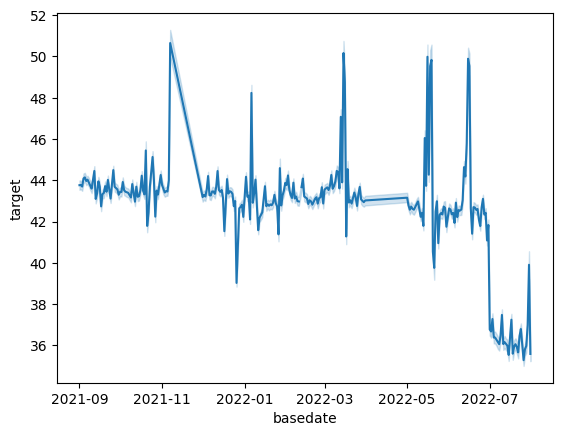

In [ ]:
#시계열 basedate에 따른 target확인하기.: 너무 오래 걸려서 # 걸어둠
#sns.lineplot(data=train, x='basedate', y='target')


-> 2021년 11~12월에 특히 높은 것 확인  
-> 그 외에는 별다른 주기가 보이진 않으나 한번씩 치솟을 때가 있음.

In [ ]:
#시간대 별 평균 확인 및 도표 그리기
train.groupby(["base_hour"])["target"].mean()

base_hour
0     48.742200
1     49.763300
2     50.278658
3     50.543254
4     49.747525
5     47.201140
6     45.549029
7     43.682268
8     41.656292
9     40.875939
10    40.222232
11    39.824593
12    39.838538
13    39.731471
14    39.561121
15    39.351700
16    39.127929
17    38.473363
18    38.241258
19    40.104112
20    41.113806
21    42.173431
22    43.989862
23    45.807739
Name: target, dtype: float64

<Axes: ylabel='target'>

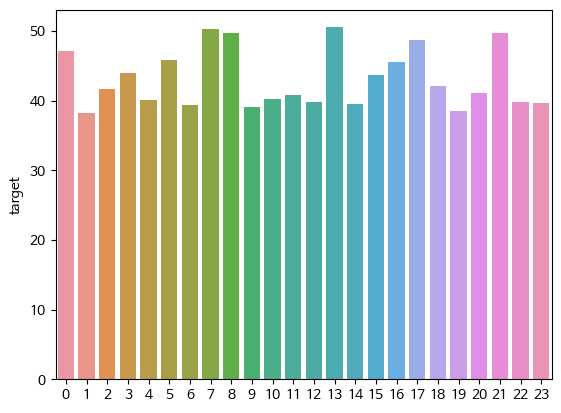

In [ ]:
sns.barplot(x = train.base_hour.unique(), y = train.groupby("base_hour")["target"].mean())
#출근시간과 퇴근시간, 밤 시간

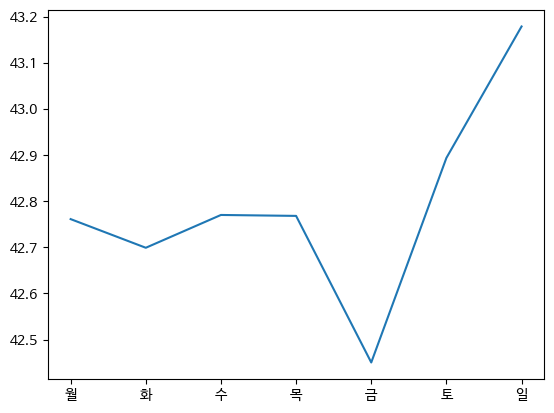

In [ ]:
# 요일 별 그래프 그리기
train.day_of_week.unique()
weekdays = ['월', '화', '수', '목', '금', '토', '일']

grouped = train.groupby('day_of_week')['target'].mean().reindex(weekdays)

plt.plot(grouped.index, grouped.values)

- 주말에 특히 많으며 금요일에 보통 떨어짐.

## 위도 경도

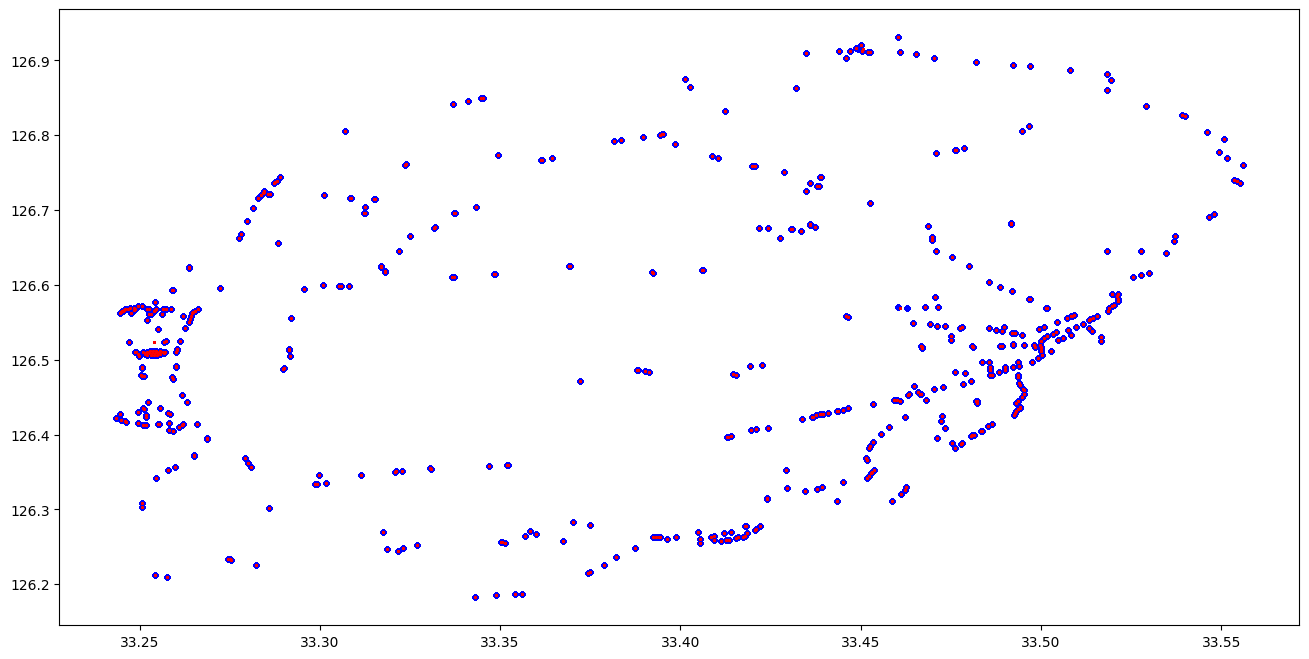

In [ ]:
#위도 경도 별로 산점도
#시작과 끝이 차이가 별로 없음
plt.figure(figsize=(16, 8))
plt.scatter(
    train.start_latitude,
    train.start_longitude,
    s=10,
    c='blue'
)
plt.scatter(
    train.end_latitude,
    train.end_longitude,
    s=0.1,
    c='red'
)

plt.show()

## 상관관계 행렬

<ipython-input-32-9f232b47c862>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot = True)


<Axes: >

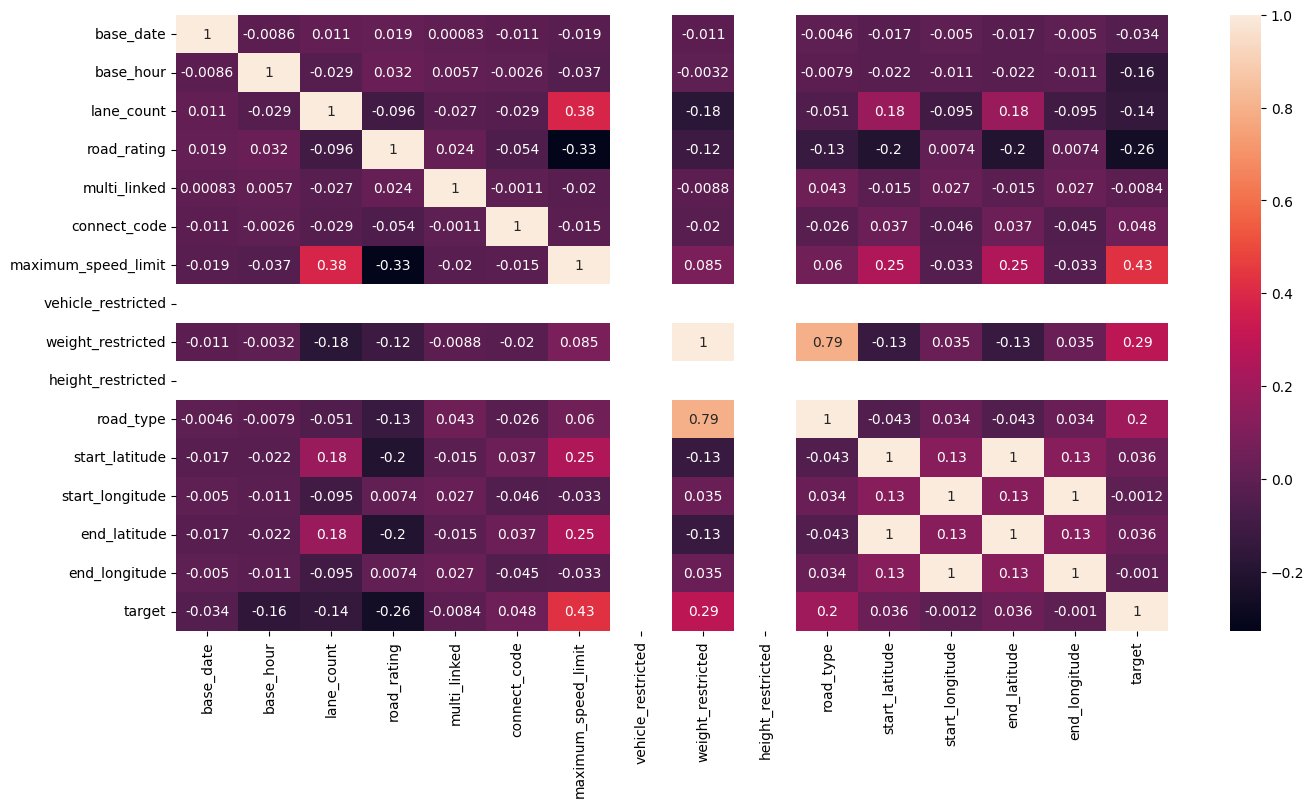

In [ ]:
plt.figure(figsize = (16,8))
sns.heatmap(train.corr(), annot = True)

In [ ]:
#vehicle_restricted와 height_restricted가 이상하므로 확인해봄
print(train.groupby(["vehicle_restricted"])["target"].size())
print(train.groupby(["height_restricted"])["target"].size())

vehicle_restricted
0.0    4701217
Name: target, dtype: int64
height_restricted
0.0    4701217
Name: target, dtype: int64


In [ ]:
#모두 0으로 의미없는 값을 가지고 있으므로 삭제하고 다시 corr확인
train.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)
test.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)

<ipython-input-37-9f232b47c862>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot = True)


<Axes: >

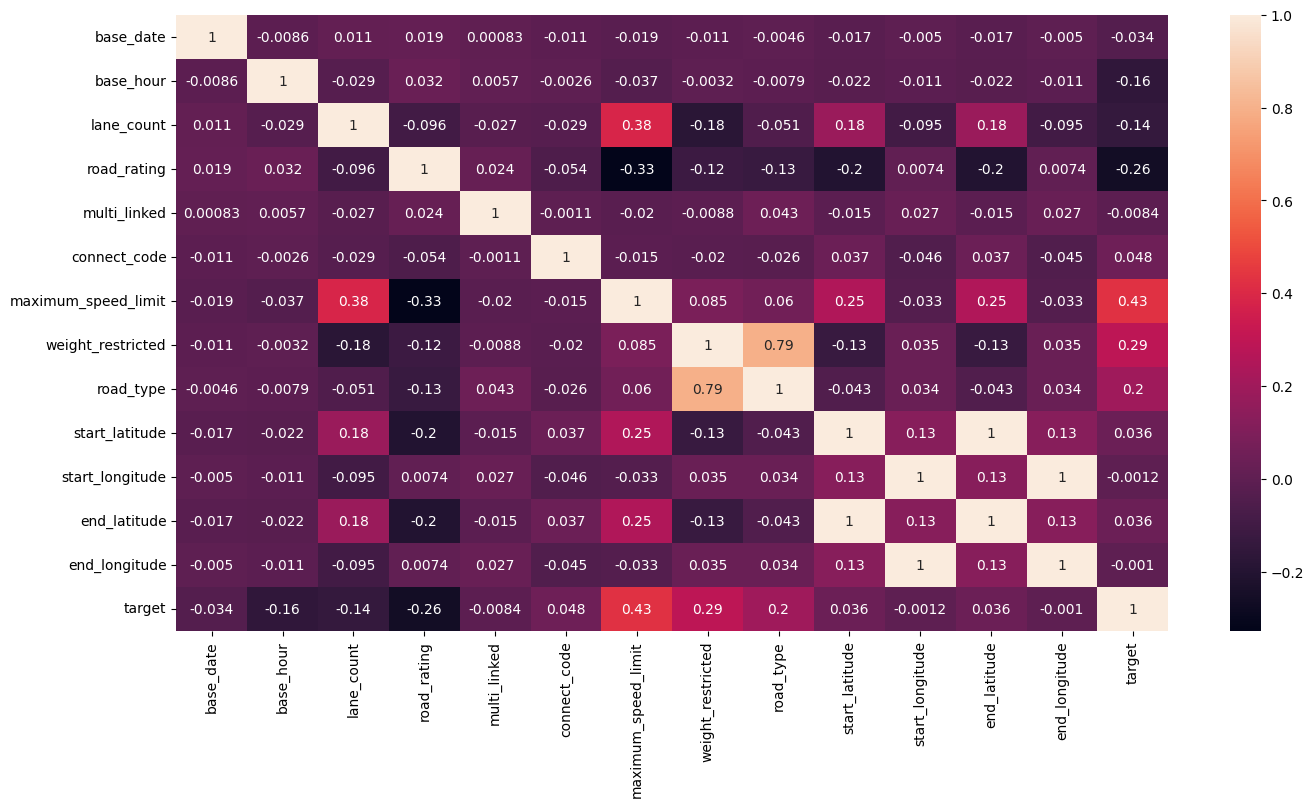

In [ ]:
plt.figure(figsize = (16,8))
sns.heatmap(train.corr(), annot = True)

- maximum_speed_limit 변수가 target에 대해 비교적 높은 상관관계를 지님
- 시작 위도, 경도와 끝 위도, 경도는 합쳐도 될 듯함..?(?)

##maximum_speed_limit 변수

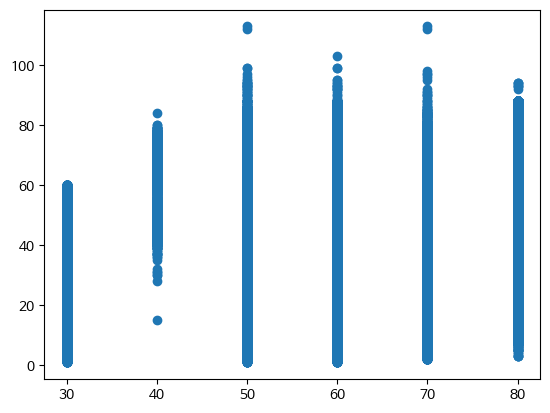

In [ ]:
plt.scatter(
    train.maximum_speed_limit,
    train.target,
)

<Axes: xlabel='maximum_speed_limit', ylabel='target'>

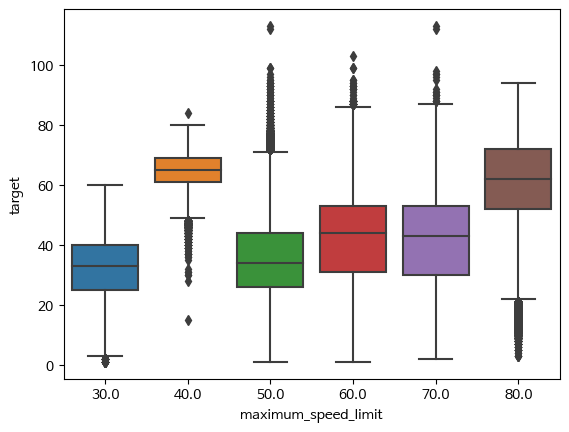

In [ ]:
sns.boxplot(x = train.maximum_speed_limit, y = train.target)